In [42]:
import pandas as pd
import numpy as np
from keras.src.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
from sklearn.metrics import r2_score
import time
import tracemalloc


In [43]:
file_path = r'C:\Users\Χριστόδουλος\Desktop\ML project\cleaned_energy_data.csv'
df = pd.read_csv(file_path)

In [44]:
target_column = 'Appliances' 
features = df.columns.difference([target_column])

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute

df = df.select_dtypes(include=['float64', 'int64', 'int32'])
features = df.select_dtypes(include=['float64', 'int64']).columns


In [45]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features])

sequence_length = 50 
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i - sequence_length:i])
    y.append(df[target_column].iloc[i])  

X = np.array(X)
y = np.array(y)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
def build_model(units=50, optimizer='sgd', dropout=0.2):
    model = Sequential()
    model.add(Input(shape=(sequence_length, 44))) 
    model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer, loss='mse', metrics=['mae'])
    
    return model

In [54]:
model = build_model()

start_time = time.time()
tracemalloc.start()

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    verbose=0
)

end_time = time.time()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {np.sqrt(test_loss):.4f}")
print(f"Test MAPE: {test_mae/np.mean(y_test)*100:.4f}")
print(f"Test R2: {r2_score(y_test, model.predict(X_test)):.4f}")
print("Training time (s):", end_time - start_time)
print("Memory usage (Bytes):", current)

y_pred = model.predict(X_test)

Test Loss: 133.0807
Test MAE: 9.6339
Test RMSE: 11.5361
Test MAPE: 18.1343
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Test R2: -0.8617
Training time (s): 9.804651737213135
Memory usage (Bytes): 6618133
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


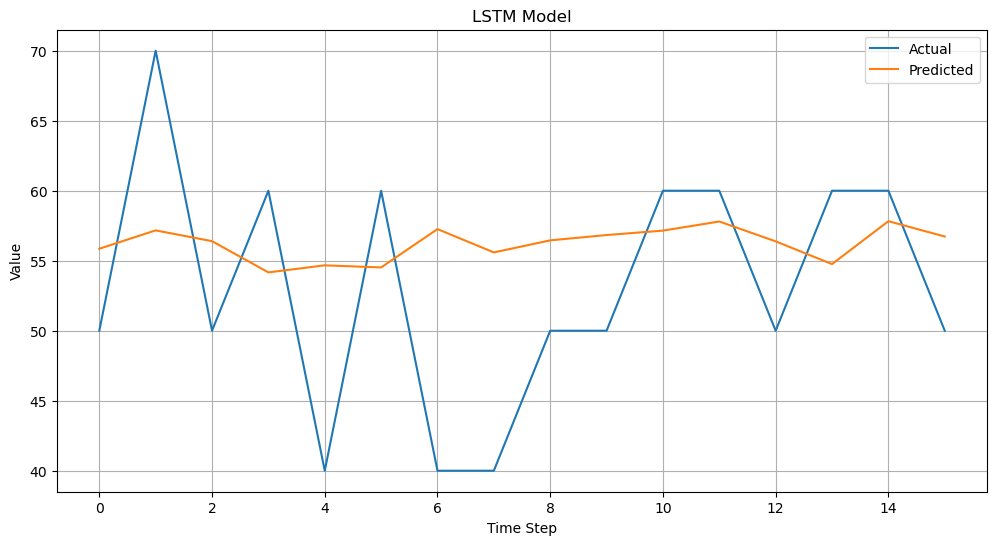

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual') 
plt.plot(y_pred.flatten(), label='Predicted')  
plt.title('LSTM Model')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

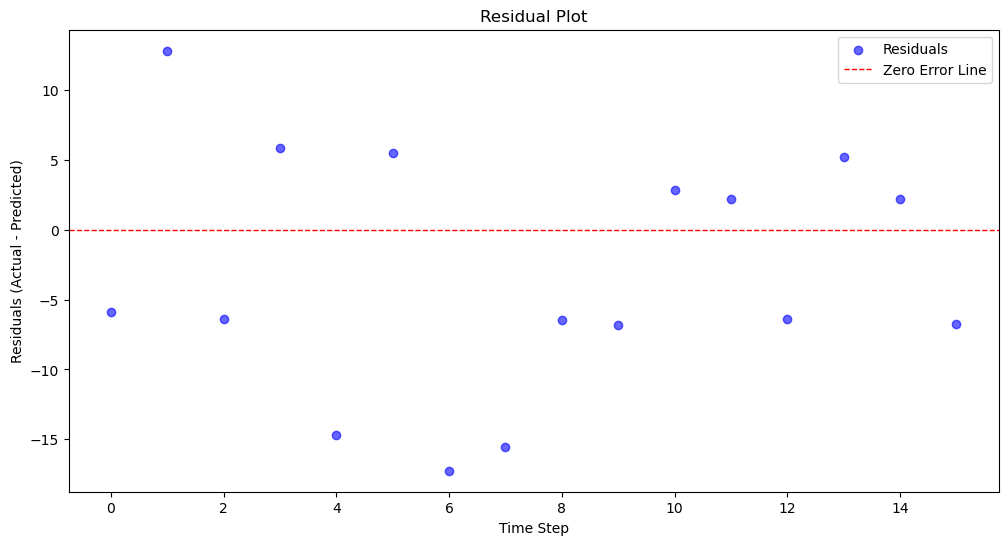

In [50]:
y_test = y_test.reshape(-1) if len(y_test.shape) > 1 else y_test
y_pred = y_pred.reshape(-1) if len(y_pred.shape) > 1 else y_pred

min_length = min(len(y_test), len(y_pred))
y_test_aligned = y_test[:min_length]
y_pred_aligned = y_pred[:min_length]

residuals = y_test - y_pred

plt.figure(figsize=(12, 6))
plt.scatter(range(len(residuals)), residuals, color='blue', alpha=0.6, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, label='Zero Error Line')
plt.title('Residual Plot')
plt.xlabel('Time Step')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

In [51]:
def train_and_evaluate_model(units, dropout, optimizer, batch_size, epochs):
    model = build_model(units, optimizer, dropout)
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=0)
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    
    return mae 

In [52]:
units_list = [50, 100, 150]  
dropout_list = [0.2, 0.3, 0.5]  
batch_size_list = [16, 32] 
epochs_list = [10, 20]  
optimizer_list = ['adam', 'sgd']  

In [53]:
def train_and_evaluate_model(units, dropout, optimizer, batch_size, epochs):
    model = build_model(units, optimizer, dropout)

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=0)

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    return mae, rmse, mape, r2

best_mae = float('inf')
best_rmse = float('inf')
best_mape = float('inf')
best_r2 = float('-inf')

best_params = {
    'mae': {},
    'rmse': {},
    'mape': {},
    'r2': {}
}

for units in units_list:
    for dropout in dropout_list:
        for batch_size in batch_size_list:
            for epochs in epochs_list:
                for optimizer in optimizer_list:
                    print(f"Training model with units={units}, dropout={dropout}, batch_size={batch_size}, epochs={epochs}, optimizer={optimizer}")

                    mae, rmse, mape, r2 = train_and_evaluate_model(units, dropout, optimizer, batch_size, epochs)


                    if mae < best_mae:
                        best_mae = mae
                        best_params['mae'] = {
                            'units': units,
                            'dropout': dropout,
                            'batch_size': batch_size,
                            'epochs': epochs,
                            'optimizer': optimizer
                        }


                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params['rmse'] = {
                            'units': units,
                            'dropout': dropout,
                            'batch_size': batch_size,
                            'epochs': epochs,
                            'optimizer': optimizer
                        }


                    if mape < best_mape:
                        best_mape = mape
                        best_params['mape'] = {
                            'units': units,
                            'dropout': dropout,
                            'batch_size': batch_size,
                            'epochs': epochs,
                            'optimizer': optimizer
                        }


                    if r2 > best_r2:
                        best_r2 = r2
                        best_params['r2'] = {
                            'units': units,
                            'dropout': dropout,
                            'batch_size': batch_size,
                            'epochs': epochs,
                            'optimizer': optimizer
                        }


print("\nBest hyperparameters found:")
print(f"Best MAE: {best_mae} with parameters {best_params['mae']}")
print(f"Best RMSE: {best_rmse} with parameters {best_params['rmse']}")
print(f"Best MAPE: {best_mape}% with parameters {best_params['mape']}")
print(f"Best R²: {best_r2} with parameters {best_params['r2']}")

Training model with units=50, dropout=0.2, batch_size=16, epochs=10, optimizer=adam
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Training model with units=50, dropout=0.2, batch_size=16, epochs=10, optimizer=sgd
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Training model with units=50, dropout=0.2, batch_size=16, epochs=20, optimizer=adam
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Training model with units=50, dropout=0.2, batch_size=16, epochs=20, optimizer=sgd
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Training model with units=50, dropout=0.2, batch_size=32, epochs=10, optimizer=adam
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Training model with units=50, dropout=0.2, batch_size=32, epochs=10, optimizer=sgd
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
Training model with units=50, dropout=0.2, batch_size=32, epochs=20, optimizer=adam
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Training model with units=50, dropout=0.2, batch_size=32, epochs=20, optimizer=sgd
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Training model with 